# Computer Vision NuSa (Detect Food)

## A. Import Library dan Data

In [2]:
import os
import shutil
from PIL import Image
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

import tensorflow_hub as hub


print(tf. __version__)

2.12.0


In [3]:
#!ls /datasets/drive-nusa/'Dataset Gambar Makanan'/Ariel
#!ls /datasets/drive-nusa/'Dataset Gambar Makanan'/daniel
#!ls /datasets/drive-nusa/'Dataset Gambar Makanan'/Hakim

#cp -r /datasets/drive-nusa/'Dataset Gambar Makanan'/Ariel /work
#cp -r /datasets/drive-nusa/'Dataset Gambar Makanan'/daniel /work
#cp -r /datasets/drive-nusa/'Dataset Gambar Makanan'/Hakim /work

#import shutil
#shutil.make_archive('Ariel', 'zip', '/work/Ariel')
#shutil.make_archive('Daniel', 'zip', '/work/daniel')
#shutil.make_archive('Hakim', 'zip', '/work/Hakim')

#!cp /work/Ariel.zip /datasets/drive-nusa/'Dataset Gambar Makanan'/
#!cp /work/Daniel.zip /datasets/drive-nusa/'Dataset Gambar Makanan'/
#!cp /work/Hakim.zip /datasets/drive-nusa/'Dataset Gambar Makanan'/

In [4]:
# Download folder zip
!gdown 1hWelwcYin6LMIKFMuqzH32JdLIhguwhb #download Ariel.zip
!gdown 1GGUQ0W5dZv3vS2fV8vVaHXsiAlB1nGY3 #download Daniel.zip
!gdown 11-MtpSFP27n_tJcj3lLkhC4TE6OW2lPZ #download Hakim.zip

Downloading...
From: https://drive.google.com/uc?id=1hWelwcYin6LMIKFMuqzH32JdLIhguwhb
To: /content/Ariel.zip
100% 17.2M/17.2M [00:00<00:00, 132MB/s]
Downloading...
From: https://drive.google.com/uc?id=1GGUQ0W5dZv3vS2fV8vVaHXsiAlB1nGY3
To: /content/Daniel.zip
100% 59.3M/59.3M [00:00<00:00, 104MB/s]
Downloading...
From: https://drive.google.com/uc?id=11-MtpSFP27n_tJcj3lLkhC4TE6OW2lPZ
To: /content/Hakim.zip
100% 59.9M/59.9M [00:00<00:00, 111MB/s]


In [5]:
if os.path.exists('./Data'):
    shutil.rmtree('./Data')

if os.path.exists('./tmp'):
    shutil.rmtree('./tmp')

In [6]:
!unzip Ariel.zip -d ./Data/
!unzip Daniel.zip -d ./Data/
!unzip Hakim.zip -d ./Data/

Archive:  Ariel.zip
   creating: ./Data/Lele Goreng/
  inflating: ./Data/Lele Goreng/Lele1.jpeg  
  inflating: ./Data/Lele Goreng/Lele10.jpeg  
  inflating: ./Data/Lele Goreng/Lele100.jpeg  
  inflating: ./Data/Lele Goreng/Lele11.jpeg  
  inflating: ./Data/Lele Goreng/Lele12.jpeg  
  inflating: ./Data/Lele Goreng/Lele13.jpeg  
  inflating: ./Data/Lele Goreng/Lele14.jpeg  
  inflating: ./Data/Lele Goreng/Lele15.jpeg  
  inflating: ./Data/Lele Goreng/Lele16.jpeg  
  inflating: ./Data/Lele Goreng/Lele17.jpeg  
  inflating: ./Data/Lele Goreng/Lele18.jpeg  
  inflating: ./Data/Lele Goreng/Lele19.jpeg  
  inflating: ./Data/Lele Goreng/Lele2.jpeg  
  inflating: ./Data/Lele Goreng/Lele20.jpeg  
  inflating: ./Data/Lele Goreng/Lele21.jpeg  
  inflating: ./Data/Lele Goreng/Lele22.jpeg  
  inflating: ./Data/Lele Goreng/Lele23.jpeg  
  inflating: ./Data/Lele Goreng/Lele24.jpeg  
  inflating: ./Data/Lele Goreng/Lele25.jpeg  
  inflating: ./Data/Lele Goreng/Lele26.jpeg  
  inflating: ./Data/Lele Gor

## B. Preprocessing Data
- Split data training 80%
- Split data validation 20%

### 1. Split Data

In [7]:
# Count Image Food
list_food = ['Ayam Goreng','Bakso','Bubur Ayam',
'ikan goreng','Lele Goreng','lontong','Mi Goreng','Nasi Putih',
'pempek','Sate','singkong goreng', 'Soto', 'Telur Dadar', 'Telur Mata Sapi', 'tempe goreng']

im1 = Image.open(r'./Data/ikan goreng/ikangoreng19.png')
im1 = im1.convert('RGB')
im1.save(r'./Data/ikan goreng/ikangoreng19.jpeg')

source_path = './Data'

# Deletes all non-image files (there are two .db files bundled into the dataset)
!find ./Data -type f ! -name "*.jpeg" -exec rm {} +


def food_img_count(food):
    source_path_food = os.path.join(source_path, food)
    # os.listdir returns a list containing all files under the given path
    print(f"There are {len(os.listdir(source_path_food))} images of {food}.")

for food in list_food:
    food_img_count(food)

There are 100 images of Ayam Goreng.
There are 100 images of Bakso.
There are 100 images of Bubur Ayam.
There are 100 images of ikan goreng.
There are 100 images of Lele Goreng.
There are 100 images of lontong.
There are 100 images of Mi Goreng.
There are 100 images of Nasi Putih.
There are 100 images of pempek.
There are 100 images of Sate.
There are 100 images of singkong goreng.
There are 100 images of Soto.
There are 100 images of Telur Dadar.
There are 100 images of Telur Mata Sapi.
There are 100 images of tempe goreng.


In [8]:
# Define root directory and make train directory and val directory
root_dir = './tmp/food_detector'

# Empty directory to prevent FileExistsError is the function is run several times
if os.path.exists(root_dir):
    shutil.rmtree(root_dir)

train_dir = os.path.join(root_dir, 'training')
validation_dir = os.path.join(root_dir, 'validation')

os.makedirs(train_dir)
os.makedirs(validation_dir)

# GRADED FUNCTION: create_train_val_dirs
def create_train_val_dirs(root_path, food):
    """
    Creates directories for the train and test sets
    
    Args:
    root_path (string) - the base directory path to create subdirectories from
    
    Returns:
    None
    """
    
    train_food_dir = os.path.join(train_dir, food)
    validation_food_dir = os.path.join(validation_dir, food)

    os.makedirs(train_food_dir)
    os.makedirs(validation_food_dir)

  
try:
    for food in list_food:
        create_train_val_dirs(root_dir,food)
except FileExistsError:
    print("You should not be seeing this since the upper directory is removed beforehand")

In [9]:
for rootdir, dirs, files in os.walk(root_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

./tmp/food_detector/validation
./tmp/food_detector/training
./tmp/food_detector/validation/Ayam Goreng
./tmp/food_detector/validation/lontong
./tmp/food_detector/validation/Nasi Putih
./tmp/food_detector/validation/pempek
./tmp/food_detector/validation/ikan goreng
./tmp/food_detector/validation/Sate
./tmp/food_detector/validation/Soto
./tmp/food_detector/validation/Mi Goreng
./tmp/food_detector/validation/tempe goreng
./tmp/food_detector/validation/singkong goreng
./tmp/food_detector/validation/Bubur Ayam
./tmp/food_detector/validation/Lele Goreng
./tmp/food_detector/validation/Telur Dadar
./tmp/food_detector/validation/Telur Mata Sapi
./tmp/food_detector/validation/Bakso
./tmp/food_detector/training/Ayam Goreng
./tmp/food_detector/training/lontong
./tmp/food_detector/training/Nasi Putih
./tmp/food_detector/training/pempek
./tmp/food_detector/training/ikan goreng
./tmp/food_detector/training/Sate
./tmp/food_detector/training/Soto
./tmp/food_detector/training/Mi Goreng
./tmp/food_detect

In [10]:
# Splitting Data
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):
    """
    Splits the data into train and test sets
  
    Args:
        SOURCE_DIR (string): directory path containing the images
        TRAINING_DIR (string): directory path to be used for training
        VALIDATION_DIR (string): directory path to be used for validation
        SPLIT_SIZE (float): proportion of the dataset to be used for training
    
    Returns:
        None
    """
  
    source_list = os.listdir(SOURCE_DIR)
    train_len = int(len(source_list)*SPLIT_SIZE)
    train_list = random.sample((source_list), train_len)
    validation_list = [x for x in source_list if x not in train_list]
  
    for im in source_list:
        im_source = os.path.join(SOURCE_DIR, im)
        if os.path.getsize(im_source)==0:
            print(im+" is zero length, so ignoring.")
        else:
            if im in train_list:
                shutil.copyfile(im_source, os.path.join(TRAINING_DIR, im))
            else:
                shutil.copyfile(im_source, os.path.join(VALIDATION_DIR, im))

In [11]:
# Test your split_data function

def split_data_combine(food):
    # Define paths
    FOOD_SOURCE_DIR = "./Data/{}/".format(food)
    
    TRAINING_DIR = "./tmp/food_detector/training/"
    VALIDATION_DIR = "./tmp/food_detector/validation/"
    
    TRAINING_FOOD_DIR = os.path.join(TRAINING_DIR, "{}/".format(food))
    VALIDATION_FOOD_DIR = os.path.join(VALIDATION_DIR, "{}/".format(food))
    
    # Empty directories in case you run this cell multiple times
    
    if len(os.listdir(TRAINING_FOOD_DIR)) > 0:
        for file in os.scandir(TRAINING_FOOD_DIR):
            os.remove(file.path)
            
    if len(os.listdir(VALIDATION_FOOD_DIR)) > 0:
        for file in os.scandir(VALIDATION_FOOD_DIR):
            os.remove(file.path)
    
    # Define proportion of images used for training
    split_size = 0.8
    
    # Run the function
    # NOTE: Messages about zero length images should be printed out
    split_data(FOOD_SOURCE_DIR, TRAINING_FOOD_DIR, VALIDATION_FOOD_DIR, split_size)

    # Your function should perform copies rather than moving images so original directories should contain unchanged images
    print(f"\n\nOriginal {food}'s directory has {len(os.listdir(FOOD_SOURCE_DIR))} images")

    # Training and validation splits. Check that the number of images matches the expected output.
    print(f"There are {len(os.listdir(TRAINING_FOOD_DIR))} images of {food}s for training")
    print(f"There are {len(os.listdir(VALIDATION_FOOD_DIR))} images of {food}s for validation")

for food in list_food:
    split_data_combine(food)




Original Ayam Goreng's directory has 100 images
There are 80 images of Ayam Gorengs for training
There are 20 images of Ayam Gorengs for validation


Original Bakso's directory has 100 images
There are 80 images of Baksos for training
There are 20 images of Baksos for validation


Original Bubur Ayam's directory has 100 images
There are 80 images of Bubur Ayams for training
There are 20 images of Bubur Ayams for validation


Original ikan goreng's directory has 100 images
There are 80 images of ikan gorengs for training
There are 20 images of ikan gorengs for validation


Original Lele Goreng's directory has 100 images
There are 80 images of Lele Gorengs for training
There are 20 images of Lele Gorengs for validation


Original lontong's directory has 100 images
There are 80 images of lontongs for training
There are 20 images of lontongs for validation


Original Mi Goreng's directory has 100 images
There are 80 images of Mi Gorengs for training
There are 20 images of Mi Gorengs for 

### 2. Image Augmentation

In [12]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
    """
    Creates the training and validation data generators
    
    Args:
        TRAINING_DIR (string): directory path containing the training images
        VALIDATION_DIR (string): directory path containing the testing/validation images

    Returns:
        train_generator, validation_generator - tuple containing the generators
    """

    # Instantiate the ImageDataGenerator class (don't forget to set the arguments to augment the images)
    train_datagen = ImageDataGenerator(rescale=1./255.,
                                        rotation_range=40,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        shear_range=0.2,
                                        zoom_range=0.2,
                                        horizontal_flip=True,
                                        fill_mode='nearest')

    # Pass in the appropriate arguments to the flow_from_directory method
    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                        batch_size=40,
                                                        class_mode='categorical',
                                                        target_size=(224, 224))

    # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
    validation_datagen = ImageDataGenerator( rescale = 1./255.)

    # Pass in the appropriate arguments to the flow_from_directory method
    validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                    batch_size=10,
                                                                    class_mode='categorical',
                                                                    target_size=(224, 224))
    return train_generator, validation_generator

In [13]:
TRAINING_DIR = "./tmp/food_detector/training/"
VALIDATION_DIR = "./tmp/food_detector/validation/"

train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 1200 images belonging to 15 classes.
Found 300 images belonging to 15 classes.


In [14]:
train_generator, test_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 1200 images belonging to 15 classes.
Found 300 images belonging to 15 classes.


In [15]:
train_generator.class_indices

{'Ayam Goreng': 0,
 'Bakso': 1,
 'Bubur Ayam': 2,
 'Lele Goreng': 3,
 'Mi Goreng': 4,
 'Nasi Putih': 5,
 'Sate': 6,
 'Soto': 7,
 'Telur Dadar': 8,
 'Telur Mata Sapi': 9,
 'ikan goreng': 10,
 'lontong': 11,
 'pempek': 12,
 'singkong goreng': 13,
 'tempe goreng': 14}

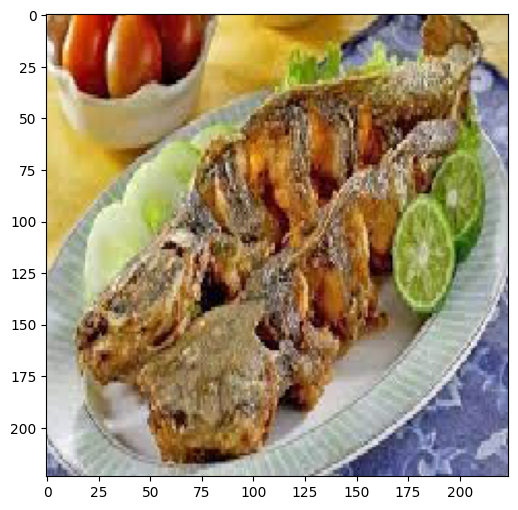

In [53]:
train_datagen = ImageDataGenerator(rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

#Loads image in from the set image path
img = tf.keras.preprocessing.image.load_img('/content/Data/Lele Goreng/Lele1.jpeg', target_size= (224,224))
img_tensor = tf.keras.preprocessing.image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

#Allows us to properly visualize our image by rescaling values in array
img_tensor /= 255.

#Plots image
plt.figure(figsize=(6,6))
plt.imshow(img_tensor[0])
plt.show()

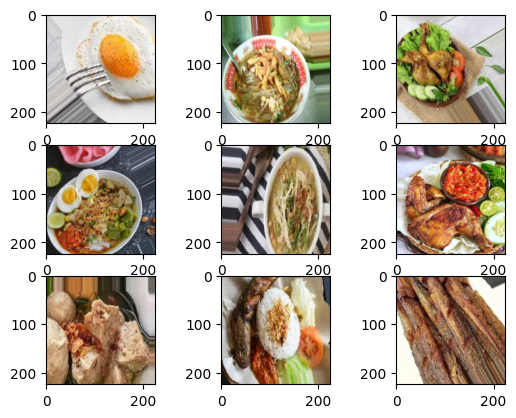

In [57]:
for image in train_generator:
  #Plots our figures
  for i,img in zip(range(1,10),image[0]):
    plt.subplot(3, 3, i)
    image_ = img
    plt.imshow(image_)
  plt.show()
  break

### Split Data and Image Augmentation Alternative
with tensorflow.keras.preprocessing.image_dataset_from_directory

In [18]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
directory = "./Data"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42,
                                             label_mode='categorical')
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42,
                                             label_mode='categorical')

Found 1500 files belonging to 15 classes.
Using 1200 files for training.
Found 1500 files belonging to 15 classes.
Using 300 files for validation.


In [19]:
test_dataset = validation_dataset

In [20]:
class_names = train_dataset.class_names
class_names

['Ayam Goreng',
 'Bakso',
 'Bubur Ayam',
 'Lele Goreng',
 'Mi Goreng',
 'Nasi Putih',
 'Sate',
 'Soto',
 'Telur Dadar',
 'Telur Mata Sapi',
 'ikan goreng',
 'lontong',
 'pempek',
 'singkong goreng',
 'tempe goreng']

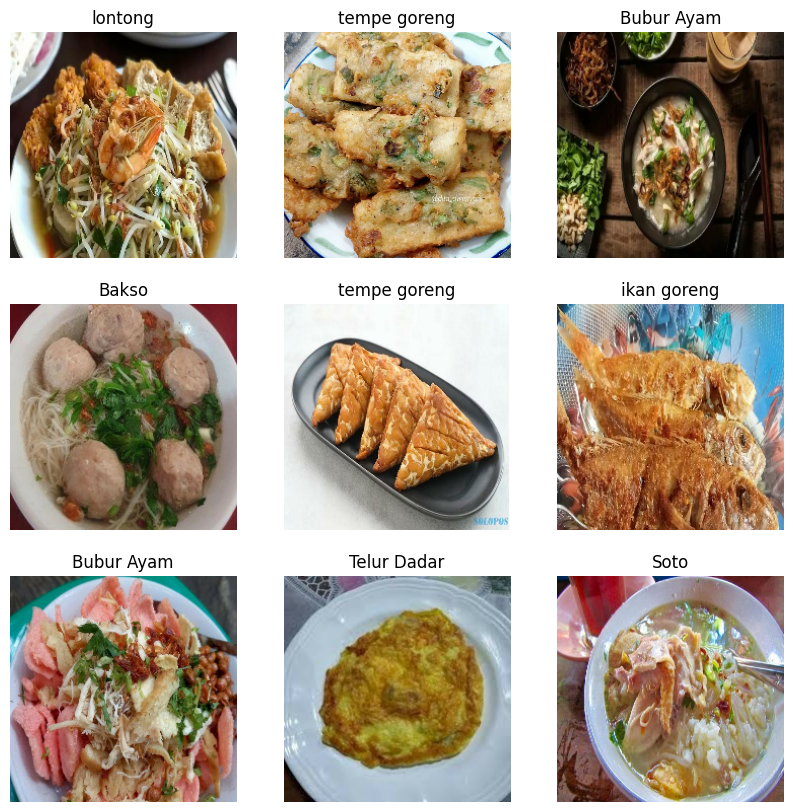

In [58]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[list(labels[i]).index(1)])
        plt.axis("off")

In [22]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [23]:
def data_augmenter():
  '''
  Create a Sequential model composed of 2 layers
  Returns:
    tf.keras.Sequential
  '''
  data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])
  return data_augmentation

In [24]:
augmenter = data_augmenter()
assert(augmenter.layers[0].name.startswith('random_flip')), "First layer must be RandomFlip"
assert augmenter.layers[0].mode == 'horizontal', "RadomFlip parameter must be horizontal"
assert(augmenter.layers[1].name.startswith('random_rotation')), "Second layer must be RandomRotation"
assert augmenter.layers[1].factor == 0.2, "Rotation factor must be 0.2"
print('\033[92mAll tests passed!')

All tests passed!


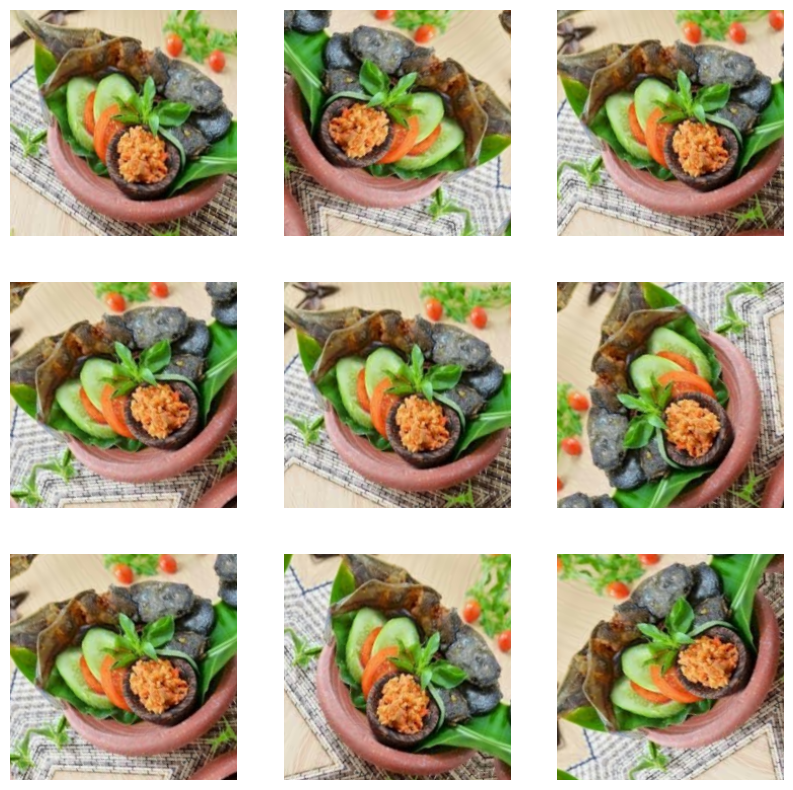

In [59]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

## C. Training Model

### Transfer Learning

In [26]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(URL,input_shape=(224, 224,3),trainable=False)

In [27]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224,3),include_top=False,weights='imagenet')
base_model.trainable = False
base_model.summary()

9406464/9406464 [==============================] - 2s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                

### Develop Model

In [28]:
def create_model():

  model = tf.keras.models.Sequential([ 
      feature_extractor,
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dense(256, activation='relu'),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(15, activation='softmax')
  ])
  
  from tensorflow.keras.optimizers import RMSprop
  model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
    
  ### END CODE HERE

  return model

In [29]:
model = create_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 15)                1935      
                                                                 
Total params: 3,080,015
Trainable params: 822,031
Non-

In [30]:
model = create_model()

history = model.fit(train_generator,
                    epochs=14,
                    verbose=1,
                    validation_data=validation_generator)

Epoch 1/14
30/30 [==============================] - 38s 849ms/step - loss: 2.2123 - accuracy: 0.2825 - val_loss: 1.3869 - val_accuracy: 0.5800
Epoch 2/14
30/30 [==============================] - 28s 925ms/step - loss: 1.3986 - accuracy: 0.5458 - val_loss: 0.9104 - val_accuracy: 0.7033
Epoch 3/14
30/30 [==============================] - 25s 831ms/step - loss: 1.0008 - accuracy: 0.6742 - val_loss: 0.6815 - val_accuracy: 0.7767
Epoch 4/14
30/30 [==============================] - 25s 840ms/step - loss: 0.7893 - accuracy: 0.7425 - val_loss: 0.6036 - val_accuracy: 0.8133
Epoch 5/14
30/30 [==============================] - 25s 836ms/step - loss: 0.6153 - accuracy: 0.7883 - val_loss: 0.6015 - val_accuracy: 0.7900
Epoch 6/14
30/30 [==============================] - 25s 836ms/step - loss: 0.5826 - accuracy: 0.8033 - val_loss: 0.4735 - val_accuracy: 0.8600
Epoch 7/14
30/30 [==============================] - 25s 841ms/step - loss: 0.5257 - accuracy: 0.8208 - val_loss: 0.6707 - val_accuracy: 0.7833

## D. Visualisasi Accuracy and Loss

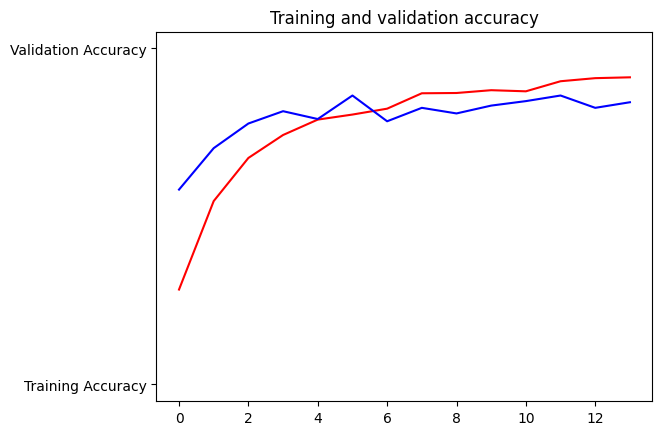

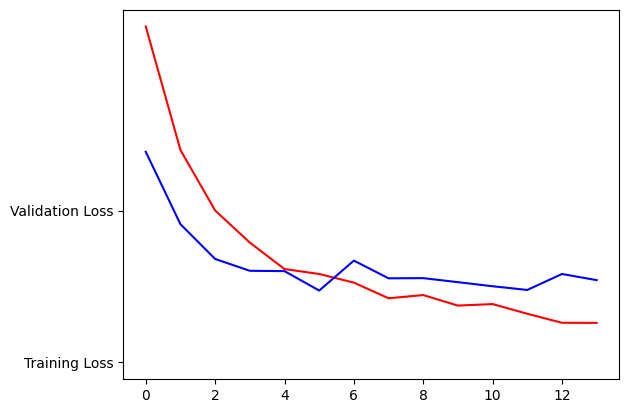

In [31]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

## E. Predicting

In [32]:
train_generator.class_indices

{'Ayam Goreng': 0,
 'Bakso': 1,
 'Bubur Ayam': 2,
 'Lele Goreng': 3,
 'Mi Goreng': 4,
 'Nasi Putih': 5,
 'Sate': 6,
 'Soto': 7,
 'Telur Dadar': 8,
 'Telur Mata Sapi': 9,
 'ikan goreng': 10,
 'lontong': 11,
 'pempek': 12,
 'singkong goreng': 13,
 'tempe goreng': 14}

In [33]:
plt.figure(figsize=(10, 10))
import numpy as np

from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

from PIL import Image

uploaded=files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path='/content/' + fn
  img=load_img(path, target_size=(224, 224))
  
  x=img_to_array(img)
  x /= 255
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])
  
  classes = model.predict(images, batch_size=40)
  label_name = list(filter(lambda x: train_generator.class_indices[x] == np.argmax(classes), train_generator.class_indices))[0]
  print( f"{classes}, category: {np.argmax(classes)}, label: {label_name}")

Saving Ayam.jpeg to Ayam.jpeg
1/1 [==============================] - 2s 2s/step
[[9.99919295e-01 4.47414413e-06 1.09213495e-07 4.86195531e-05
  4.84116242e-07 5.78274580e-07 9.42812051e-07 1.36935554e-07
  2.64844698e-06 2.98922515e-07 1.69611121e-05 4.00330191e-06
  1.68242806e-08 1.16923457e-06 1.19119726e-07]], category: 0, label: Ayam Goreng


<Figure size 1000x1000 with 0 Axes>